#Imports and Reading Data

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
with open('gp_data_train.csv', 'r', encoding = 'utf-8') as f:
    train = np.genfromtxt(f, dtype = float, delimiter = ',')
with open('gp_data_test.csv', 'r', encoding = 'utf-8') as f:
    test = np.genfromtxt(f, dtype = float, delimiter = ',')

# Funcs

In [3]:
def NormalizeZScore(dataset: np.ndarray):
    dataX = dataset[:, :-1]
    Xmean = np.mean(dataX, axis = 0)
    Xstd = np.std(dataX, axis = 0)
    dataX = (dataX - Xmean)/Xstd
    dataY = dataset[:, -1]
    Ymean = np.mean(dataY, axis = 0, keepdims = True)
    Ystd = np.std(dataY, axis = 0, keepdims = True)
    dataY = (dataY - Ymean)/Ystd
    return dataX, Xmean, Xstd, dataY, Ymean, Ystd

def NormalizePoint(p, mean, std):
    return (p-mean)/std
def DenormalizePoint(p, mean, std):
    return (p*std) + mean

In [4]:
def RBF(x1: np.ndarray, x2: np.ndarray, varf: float, w2: np.ndarray):
  if x1.ndim == 1:
    x1 = x1[:, None]
  return varf * np.exp((-1/2) * (np.sum(w2 * ((x1-x2) ** 2), axis = 1)))

In [5]:
def GP(X: np.ndarray, Y: np.ndarray):
  N = X.shape[0]
  varf = np.var(Y)
  vary = 0.01*varf
  w2 = np.apply_along_axis(lambda x: 1/(np.var(x)), arr = X, axis = 0)
  K = np.zeros((N,N))
  for i in range(N):
    for j in range(N):
      K[i, j] = RBF(X[i], X[j], varf, w2)
  return varf, vary, w2, K

In [6]:
def PredGP(xpred: np.ndarray, X: np.ndarray, Y: np.ndarray, varf: float, vary: float, w2: np.ndarray, K: np.ndarray):
  kf = np.apply_along_axis(RBF, arr = xpred, axis = 1, x2 = X, varf = varf, w2 = w2)
  N = X.shape[0]
  aux = kf @ np.linalg.inv(K + (vary * np.eye(N)))
  mean = aux @ Y
  var = RBF(xpred, xpred, varf, w2) - np.diag(aux @ kf.reshape((N, -1)))
  return mean, var

# Running

## Normalizing/Split

In [7]:
trainXN, Xmean, Xstd, trainYN, Ymean, Ystd = NormalizeZScore(train)

## Train/Eval

In [8]:
varf, vary, w2, K = GP(trainXN, trainYN)

In [9]:
trainPredN_mean, trainPredN_var = PredGP(trainXN, trainXN, trainYN, varf, vary, w2, K)
trainPredN_std = np.sqrt(trainPredN_var)
trainPred_mean = DenormalizePoint(trainPredN_mean, Ymean, Ystd)
trainPred_std = DenormalizePoint(trainPredN_std, Ymean, Ystd)
trainPred_var = trainPred_std ** 2

In [10]:
trainY = train[:, -1]
RMSE = np.sqrt(np.mean((trainPred_mean - trainY)**2))
NLPD = ((1/2)*np.log(2*np.pi)) + ((1/(2*trainY.shape[0])) * np.sum(np.log(trainPred_var) + (((trainY - trainPred_mean)**2)/trainPred_var)))
print(f"Treino: \nRMSE: {RMSE} \nNLPD: {NLPD}")

Treino: 
RMSE: 0.2296261184903573 
NLPD: 3.792453617668738


In [11]:
testX = test[:, :-1]
testY = test[:, -1]
testXN = NormalizePoint(testX, Xmean, Xstd)
testPredN_mean, testPredN_var = PredGP(testXN, trainXN, trainYN, varf, vary, w2, K)
testPredN_std = np.sqrt(testPredN_var)
testPred_mean = DenormalizePoint(testPredN_mean, Ymean, Ystd)
testPred_std = DenormalizePoint(testPredN_std, Ymean, Ystd)
testPred_var = testPred_std ** 2

In [12]:
RMSE = np.sqrt(np.mean((testPred_mean - testY)**2))
NLPD = (1/2)*np.log(2*np.pi) + ((1/(2*testY.shape[0])) * np.sum(np.log(testPred_var) + (((testY - testPred_mean)**2)/testPred_var)))
print(f"Teste: \nRMSE: {RMSE} \nNLPD: {NLPD}")

Teste: 
RMSE: 0.22912156316743065 
NLPD: 0.11382384955088531


##Plot

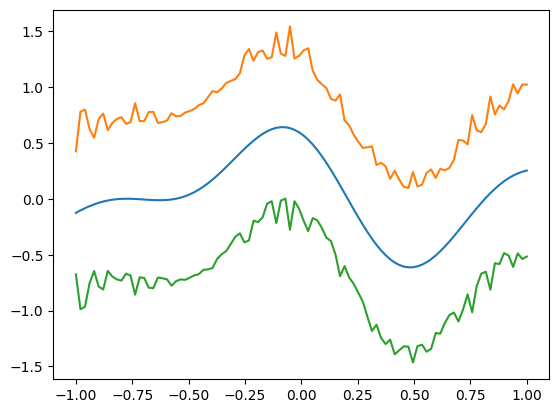

In [13]:
x_plot = np.linspace(-1, 1, 100)
x_plot_n = NormalizePoint(x_plot, Xmean, Xstd).reshape((-1, 1))
y_plot_n_mean, y_plot_n_var = PredGP(x_plot_n, trainXN, trainYN, varf, vary, w2, K)
y_plot_mean = DenormalizePoint(y_plot_n_mean, Ymean, Ystd)
y_plot_std = DenormalizePoint(np.sqrt(y_plot_n_var), Ymean, Ystd)
plt.plot(x_plot, y_plot_mean)
plt.plot(x_plot, y_plot_mean + (2*y_plot_std))
plt.plot(x_plot, y_plot_mean - (2*y_plot_std))
plt.show()